In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# <font face="gotham" color="purple"> Dynamic Econometric Models </font>

After discussions of autocorrelation, we are officially entering the realm of time series econometrics. For starter, we will discuss dynamic econometric models: **distributed-lag model** and **autogressive model**. 

In economics and finance, dependent variables and explanatory (independent) variables are rarely instantaneous, i.e. $Y$ responds to $X$'s with a lapse of time.

## <font face="gotham" color="purple"> Distributed-Lag Model (DLM) </font>

Here is a DLM with one explanatory variable $X$
$$
Y_{t}=\alpha+\beta_{0} X_{t}+\beta_{1} X_{t-1}+\beta_{2} X_{t-2}+\cdots+u_{t}
$$

### <font face="gotham" color="purple"> Ad Hoc Estimation Of DLM </font>

If you are estimating variables which have no clear economic relationship or no well-founded theoretical support, go with ad hoc estimation method. 

So you start regressing $X_t$ onto $Y_t$, then adding $X_{t-i}$ where $i \geq 1$ in each round of regression, until $t$-statistic starting to be insignificant or signs of coefficients start to be unstable.

\begin{align}
\hat{Y}_t &= a + b_0X_t\\
\hat{Y}_t &= a + b_0X_t+b_1X_{t-1}\\
\hat{Y}_t &= a + b_0X_t+b_1X_{t-1}+b_2X_{t-2}\\
\hat{Y}_t &= a + b_0X_t+b_1X_{t-1}+b_1X_{t-1}+b_3X_{t-3}\\
\end{align}

But be aware that ad hoc method is bring significant problem of multicollinearity. 

### <font face="gotham" color="purple"> Koyck Approach To DLM </font>

Koyck approach assumes that all $\beta$'s are of the same sign, furthermore
$$
\beta_{k}=\beta_{0} \lambda^{k} \quad k=0,1, \ldots
$$
where $\lambda$ is the _rate of decay_, $0<\lambda<1$.

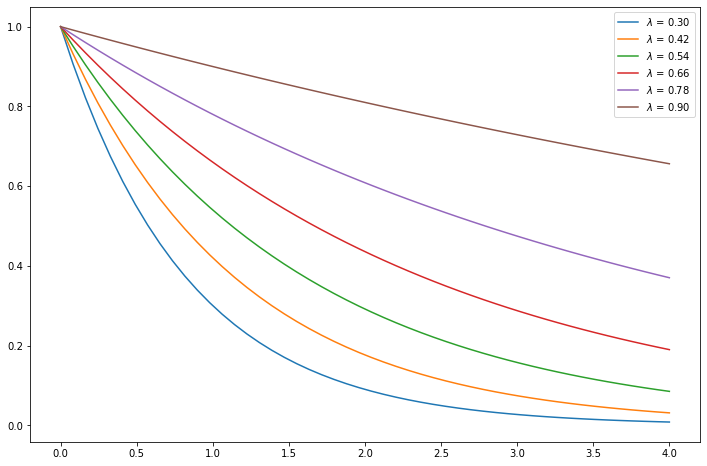

In [35]:
lamda = np.linspace(0.3, .9, 6)
beta_0 = 1
k = np.linspace(0, 4)
fig, ax = plt.subplots(figsize = (12, 8))
for i in lamda:
    beta_k = beta_0*i**k
    ax.plot(k, beta_k, label = '$\lambda$ = %.2f'%i)
ax.legend()
plt.show()

There are three perks of Koyck approach:

1. By assuming nonnegative values for $λ$, $\beta$'s sign are stable; 
2. by assuming $λ < 1$, lesser weight is given to the distant $β$'s than the current ones; 
3. The sum of the $β$'s, which gives the long-run multiplier, is finite, i.e.
$$
\sum_{k=0}^{\infty} \beta_{k}=\beta_{0}\left(\frac{1}{1-\lambda}\right)
$$

Naturally, the infinite distributed lag  model can be rewritten as
$$
Y_{t}=\alpha+\beta_{0} X_{t}+\beta_{0} \lambda X_{t-1}+\beta_{0} \lambda^{2} X_{t-2}+\cdots+u_{t}
$$